# ASSIGNMENT options

Replicate code from the lesson or other examples. [Do it "the hard way" or with the "Benjamin Franklin method."](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit)

Work with one of these datasets
- [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- [Synthetic Financial Dataset For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)
- Any imbalanced binary classification dataset

Continue improving your model. Measure validation performance with a variety of classification metrics, which could include:
- Accuracy
- Precision
- Recall
- F1
- ROC AUC

Try one of the other options mentioned for imbalanced classes
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."
- You can see how to "adjust the decision threshold" in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns


In [63]:
df= pd.read_csv("synthetic_bank_fraud.csv")

In [64]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [65]:
# x = (df.groupby("nameDest").agg({"nameDest":np.size}).sort_values("nameDest",ascending=False) >=15)==True

C:\Users\cwcol\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'nameDest' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [70]:
# x["nameDest"]==True

In [67]:
y= df["isFraud"]
X = df.drop(["isFraud","isFlaggedFraud","step","nameOrig","nameDest"],axis=1)


In [68]:
u = X["type"].unique()
for i in u:
    X[i] = X["type"].apply(lambda x : 1 if i==x else 0)

In [69]:
X.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,PAYMENT,TRANSFER,CASH_OUT,DEBIT,CASH_IN
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,1,0,0,0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,1,0,0,0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,0,1,0,0,0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,0,0,1,0,0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,1,0,0,0,0


In [71]:
X["cashout_drain"] = X["oldbalanceOrg"] * X["CASH_OUT"]
X["transfer_drain"] = X["oldbalanceOrg"] *X["TRANSFER"]

In [76]:
X =X.drop(["type"],axis=1)

In [77]:
def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [78]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X,y)

In [79]:
class_weight = {0:1,1:75}

In [80]:
pipeline = make_pipeline(
    PCA(10),
    LogisticRegression(class_weight=class_weight)
)
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight={0: 1, 1: 75}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [81]:
y_pred_val = pipeline.predict(X_val)

In [82]:
print("accuracy score: ", accuracy_score(y_val,y_pred_val))
print("ROC: ", roc_auc_score(y_val,y_pred_val) )
print(classification_report(y_val, y_pred_val))

accuracy score:  0.9941722120761574
ROC:  0.8630558044126798
             precision    recall  f1-score   support

          0       1.00      0.99      1.00    635420
          1       0.15      0.73      0.25       842

avg / total       1.00      0.99      1.00    636262



In [83]:
confusion_matrix(y_val, y_pred_val)

array([[631938,   3482],
       [   226,    616]], dtype=int64)

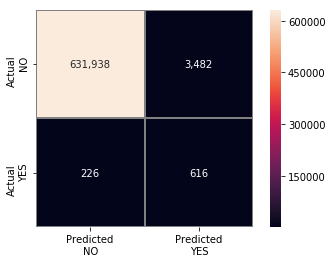

In [84]:
def confusion_viz(y_true, y_pred):
    matrix = confusion_matrix(y_true,y_pred)
    return sns.heatmap(matrix, annot=True,
                      fmt=',', linewidths=1,linecolor='grey',
                      square=True,
                      xticklabels=['Predicted\nNO', 'Predicted\nYES'], 
                       yticklabels=['Actual\nNO', 'Actual\nYES'])
confusion_viz(y_val, y_pred_val)

In [85]:
# u = X["type"].unique()
# for i in u:
#     X[i] = X["type"].apply(lambda x : 1 if i==x else 0)

# Test

In [86]:
y_pred_test = pipeline.predict(X_test)

In [87]:
print("accuracy score: ", accuracy_score(y_test,y_pred_test))
print("ROC: ", roc_auc_score(y_test,y_pred_test) )
print(classification_report(y_test, y_pred_test))

accuracy score:  0.9940904847374195
ROC:  0.8740629687094179
             precision    recall  f1-score   support

          0       1.00      0.99      1.00    635458
          1       0.15      0.75      0.24       804

avg / total       1.00      0.99      1.00    636262



In [88]:
confusion_matrix(y_val, y_pred_val)

array([[631938,   3482],
       [   226,    616]], dtype=int64)

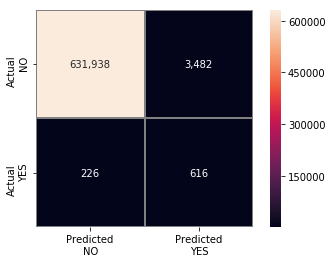

In [89]:
def confusion_viz(y_true, y_pred):
    matrix = confusion_matrix(y_true,y_pred)
    return sns.heatmap(matrix, annot=True,
                      fmt=',', linewidths=1,linecolor='grey',
                      square=True,
                      xticklabels=['Predicted\nNO', 'Predicted\nYES'], 
                       yticklabels=['Actual\nNO', 'Actual\nYES'])
confusion_viz(y_val, y_pred_val)